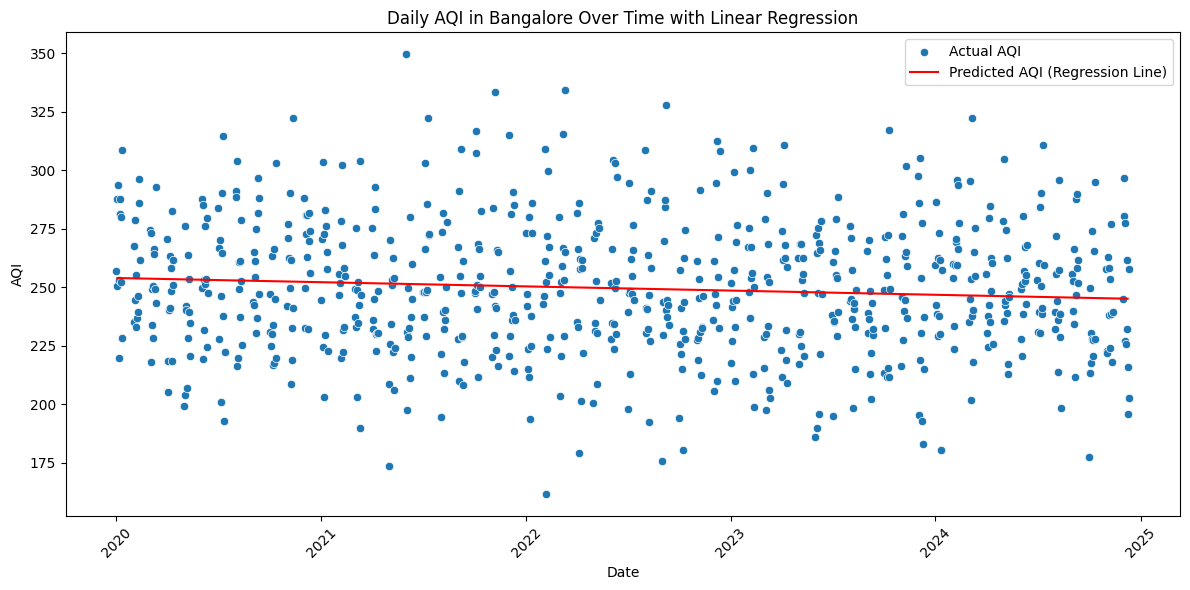

Bangalore - Mean Squared Error: 865.7383021095035
Bangalore - R-squared Score: -0.010682363925031524


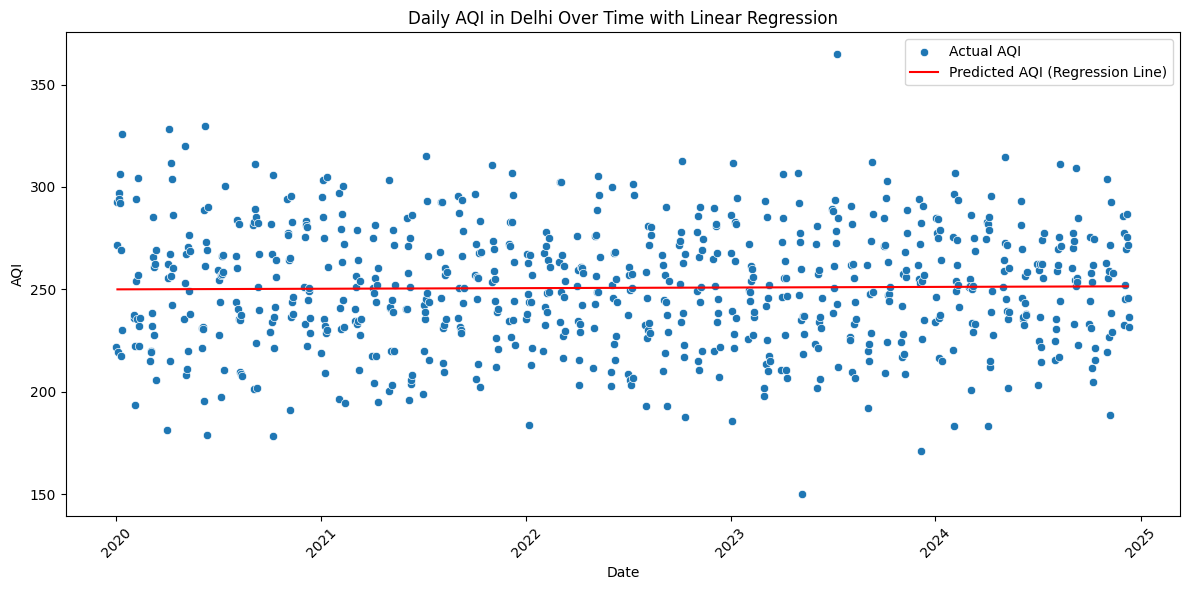

Delhi - Mean Squared Error: 824.9820266031419
Delhi - R-squared Score: -0.0015870976527632141


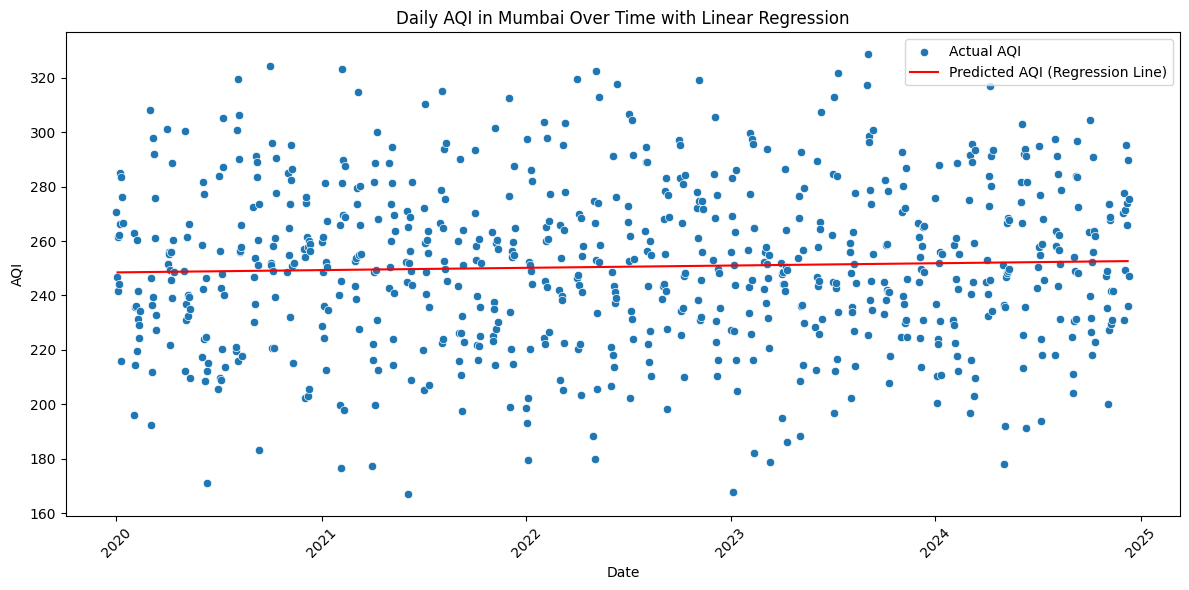

Mumbai - Mean Squared Error: 1054.380963827956
Mumbai - R-squared Score: -0.006791634123905377


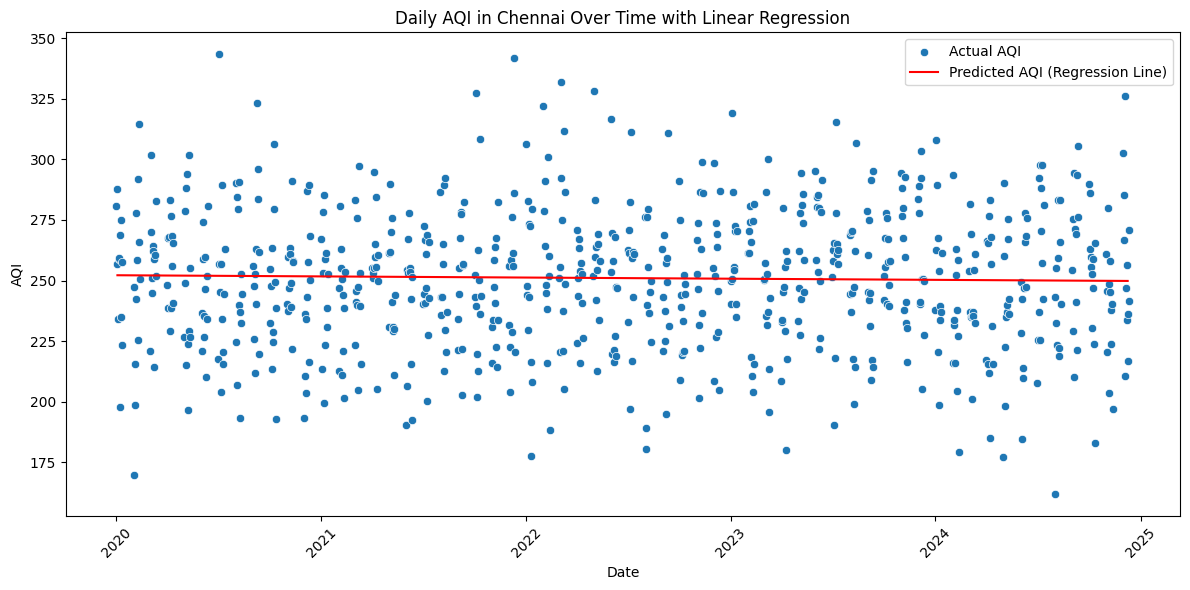

Chennai - Mean Squared Error: 805.6007733115099
Chennai - R-squared Score: -0.03428682718303744


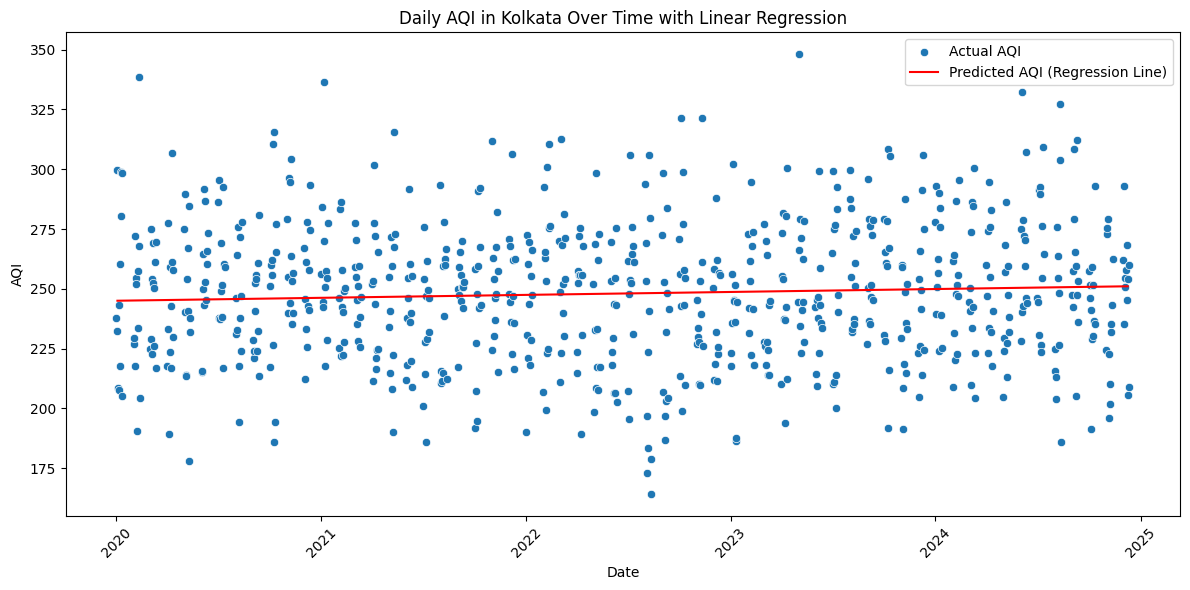

Kolkata - Mean Squared Error: 789.5089350513683
Kolkata - R-squared Score: -0.01959173413749893


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load data
df = pd.read_csv('C:/Users/HP OMEN/Downloads/archive (1)/city_hour.csv')

# Preprocessing
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df = df.dropna(subset=['Datetime'])
df = df[(df['Datetime'].dt.year >= 2020) & (df['Datetime'].dt.year <= 2024)]
df = df.sort_values(by=['City', 'Datetime']).reset_index(drop=True)
df['Date'] = df['Datetime'].dt.date  # Add this before saving

# Save cleaned file
df.to_csv('cleaned_data_2020_2024.csv', index=False)

# Group by City and Date
daily_avg_df = df.groupby(['City', 'Date']).mean(numeric_only=True).reset_index()

# Visualization and Modeling
def plot_and_model(city_name):
    city_df = daily_avg_df[daily_avg_df['City'] == city_name][['City', 'Date', 'AQI']].copy()
    city_df['Date'] = pd.to_datetime(city_df['Date'])
    city_df['Date_ordinal'] = city_df['Date'].map(pd.Timestamp.toordinal)

    # Plot actual AQI
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Date', y='AQI', data=city_df, label='Actual AQI')

    # Train/test split and linear regression
    X = city_df[['Date_ordinal']]
    y = city_df['AQI']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plot regression line
    sns.lineplot(x=pd.to_datetime(X_test['Date_ordinal'].sort_values().map(pd.Timestamp.fromordinal)),
                 y=y_pred[np.argsort(X_test['Date_ordinal'].values)],
                 color='red', label='Predicted AQI (Regression Line)')
    plt.title(f'Daily AQI in {city_name} Over Time with Linear Regression')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Print metrics
    print(f"{city_name} - Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print(f"{city_name} - R-squared Score:", r2_score(y_test, y_pred))

# Run for each city
cities = ['Bangalore', 'Delhi', 'Mumbai', 'Chennai', 'Kolkata']
for city in cities:
    plot_and_model(city)

# AQI Prediction on User Input
def get_aqi_category(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Poor'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Severe'
    else:
        return 'Hazardous'

# Load cleaned data and fix datetime
daily_avg_df = pd.read_csv('cleaned_data_2020_2024.csv')
daily_avg_df['Date'] = pd.to_datetime(daily_avg_df['Date'])

# Get user input
city_input = input("Enter city name (e.g., Delhi, Mumbai, Bangalore, Chennai, Kolkata): ").strip().title()
date_input = input("Enter a date (YYYY-MM-DD): ").strip()

try:
    user_date = pd.to_datetime(date_input)

    city_df = daily_avg_df[daily_avg_df['City'] == city_input][['Date', 'AQI']].copy()
    if city_df.empty:
        raise ValueError(f"No data found for city '{city_input}'.")

    city_df['Date_ordinal'] = city_df['Date'].map(pd.Timestamp.toordinal)
    X = city_df[['Date_ordinal']]
    y = city_df['AQI']
    model = LinearRegression()
    model.fit(X, y)

    # Predict
    date_ordinal = pd.DataFrame({'Date_ordinal': [user_date.toordinal()]})
    predicted_aqi = model.predict(date_ordinal)[0]
    category = get_aqi_category(predicted_aqi)

    print(f"\nPredicted AQI for {city_input} on {user_date.date()}: {predicted_aqi:.2f}")
    print(f"Air Quality Category: {category}")

except Exception as e:
    print("Error:", e)
